In [412]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import glob
import pandas as pd
import math
import os
import re
import geopandas as gpd
from pyarrow.parquet import ParquetFile
import sqlalchemy as db
import matplotlib.pyplot as plt

## Part 1: Data Preprocessing

In [3]:
url = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
response = requests.get(url)
if response.status_code == 200:
    print("Success")
else:
    print("Failure")

Success


In [4]:
import re
results_page = BeautifulSoup(response.content,'lxml')

#### get data from January 2009 through June 2015

In [5]:
def get_taxi_link():
    """Return an array of links of all taxi data from the website"""
    link_array = []
    pattern = r"(http.*yellow_tripdata_(20[0|1][0-9])-(0?\d*).parquet)"
    match = re.findall(pattern, str(results_page))
    for i in match:
        if int(i[1]) < 2015:
            link_array.append(i[0])
        elif int(i[1]) == 2015 and int(i[2]) <= 6:
            link_array.append(i[0])
    return link_array

In [6]:
link = get_taxi_link()

['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-06.pa

download data to local folder

In [ ]:
pattern = r"yellow.*.parquet"
for taxi_data_url in link:
    match = re.search(pattern, taxi_data_url)
    name_of_file = match.group()
    
    # to make sure we're not re-downloading the same file again
    if not os.path.exists(name_of_file):
        response = requests.get(taxi_data_url, stream=True)
        with open(name_of_file, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                

#### get all column names to normalize columns

In [ ]:
pattern = r"yellow.*.parquet"
parquet_column_list = []

for file in os.listdir():
    match = re.match(pattern, file)
    if match:
        file_name = match.group()
        df = pd.read_parquet(file_name)
        column_name = df.columns.to_list()
        if column_name not in parquet_column_list:
            parquet_column_list.append(column_name)

In [254]:
# we save the parquet column list so that later we don't need to run across each parquet file again
parquet_column_list = [['VendorID',
  'tpep_pickup_datetime',
  'tpep_dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'RatecodeID',
  'store_and_fwd_flag',
  'PULocationID',
  'DOLocationID',
  'payment_type',
  'fare_amount',
  'extra',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'improvement_surcharge',
  'total_amount',
  'congestion_surcharge',
  'airport_fee'],
 ['vendor_name',
  'Trip_Pickup_DateTime',
  'Trip_Dropoff_DateTime',
  'Passenger_Count',
  'Trip_Distance',
  'Start_Lon',
  'Start_Lat',
  'Rate_Code',
  'store_and_forward',
  'End_Lon',
  'End_Lat',
  'Payment_Type',
  'Fare_Amt',
  'surcharge',
  'mta_tax',
  'Tip_Amt',
  'Tolls_Amt',
  'Total_Amt'],
 ['vendor_id',
  'pickup_datetime',
  'dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'pickup_longitude',
  'pickup_latitude',
  'rate_code',
  'store_and_fwd_flag',
  'dropoff_longitude',
  'dropoff_latitude',
  'payment_type',
  'fare_amount',
  'surcharge',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'total_amount']]

import uber data

In [6]:
uber_data = pd.read_csv('uber_rides_sample.csv', index_col=0)
uber_data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [7]:
# change the format of key to datetime
uber_data['key'] = pd.to_datetime(uber_data['key'])

examine how many rows are there for each year and month

In [12]:
examine_df = pd.concat([uber_data['key'].dt.year, uber_data['key'].dt.month], axis=1)
examine_df.columns = ['year', 'month']

In [13]:
examine_df.groupby(['year', 'month']).size()

year  month
2009  1        2555
      2        2292
      3        2703
      4        2574
      5        2660
               ... 
2015  2        2225
      3        2362
      4        2339
      5        2449
      6        2161
Length: 78, dtype: int64

In [14]:
# number of rows needed for each month
200000/78

2564.102564102564

#### according to the average number of rows in each month each year in the sample uber dataset, we do the following:
- sample 2600 columns from the yellow taxi dataset
- remove unecessary column and normalize the yellow taxi columns by mapping their names to match the uber dataset

In [258]:
shapefile = gpd.read_file("taxi_zones/taxi_zones.shp")
shapefile

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [259]:
shapefile = shapefile.to_crs(4326)
shapefile['longitude'] = shapefile.centroid.x  
shapefile['latitude'] = shapefile.centroid.y
column_to_remove = ['Shape_Leng','Shape_Area','OBJECTID','geometry','zone','borough']
shapefile_new = shapefile.drop(columns=column_to_remove)

/var/folders/sl/ygvmf08n6s5cz73c1jv6rbnw0000gn/T/ipykernel_37224/4106857179.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['longitude'] = shapefile.centroid.x
/var/folders/sl/ygvmf08n6s5cz73c1jv6rbnw0000gn/T/ipykernel_37224/4106857179.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shapefile['latitude'] = shapefile.centroid.y


correct the wrong data in the shapefile

In [260]:
shapefile_new.loc[56, 'LocationID'] = 57
shapefile_new.loc[103, 'LocationID'] = 104
shapefile_new.loc[104, 'LocationID'] = 105

In [261]:
shapefile_new

,LocationID,longitude,latitude
0,1,-74.174000,40.691831
1,2,-73.831299,40.616745
2,3,-73.847422,40.864474
3,4,-73.976968,40.723752
4,5,-74.188484,40.552659
...,...,...,...
258,259,-73.852215,40.897932
259,260,-73.906306,40.744235
260,261,-74.013023,40.709139
261,262,-73.946510,40.775932


In [256]:
def get_center_long(locationid):
    """get the longitude fo the centroid given the location id"""
    if locationid in shapefile_new['LocationID']:
        return shapefile_new[shapefile_new['LocationID']==locationid]['longitude'].values[0]

def get_center_lat(locationid):
    """get the latitude fo the centroid given the location id"""
    if locationid in shapefile_new['LocationID']:
        return shapefile_new[shapefile_new['LocationID']==locationid]['latitude'].values[0]


#### Find a file with LocationID instead of longitude to test if the get_center_long functions work or not
#### Here, we find a file "yellow_tripdata_2011-07.parquet", then we start to test get_center_long functions 

In [20]:
pattern = r"yellow.*.parquet"
for file in os.listdir():
    match = re.match(pattern, file)
    if match:
        file_name = match.group()
        df = pd.read_parquet(file_name)
        column_name = df.columns.to_list()
        if parquet_column_list.index(column_name) == 0:
            print(file_name)
        break

yellow_tripdata_2011-07.parquet


In [ ]:
def normalize_sample_taxi(directory):
    """
    input a list of downloaded files in the local directory,
    the function will find all parquet files in the directory,
    it will return a sample of all yellow taxi parquet files in dataframe format.
    """
    yellow_taxi_data = pd.DataFrame()
    for file in directory:
        pattern = r"yellow.*.parquet"
        match = re.match(pattern, file)
        if match:
            file_name = match.group()
            df = pd.read_parquet(file_name)
            sample_df = df.sample(2600)
            column_name = sample_df.columns.to_list()

            if parquet_column_list.index(column_name) == 0:
                sample_df_column_filtered = sample_df.loc[:,['tip_amount',
                                                             'fare_amount',
                                                             'tpep_pickup_datetime',
                                                             'passenger_count',
                                                             'PULocationID',
                                                             'DOLocationID']]
                # transforme 'PULocationID', 'DOLocationID' to longitude and latitude
                sample_df_column_filtered = sample_df_column_filtered[sample_df_column_filtered['PULocationID'] != sample_df_column_filtered['DOLocationID']] 
                sample_df_column_filtered = sample_df_column_filtered[(sample_df_column_filtered['PULocationID']<=263)&(sample_df_column_filtered['DOLocationID']<=263)]
                sample_df_column_filtered['pickup_longitude'] = sample_df_column_filtered['PULocationID'].apply(get_center_long)
                sample_df_column_filtered['pickup_latitude'] = sample_df_column_filtered['PULocationID'].apply(get_center_lat)
                sample_df_column_filtered['dropoff_longitude'] = sample_df_column_filtered['DOLocationID'].apply(get_center_long)
                sample_df_column_filtered['dropoff_latitude'] = sample_df_column_filtered['DOLocationID'].apply(get_center_lat)
                sample_df_column_filtered = sample_df_column_filtered.drop(columns=['PULocationID','DOLocationID'])
                sample_df_column_filtered.columns = ['tip_amount', 'fare_amount', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
            elif parquet_column_list.index(column_name) == 1:
                sample_df_column_filtered = sample_df.loc[:,[ 'Trip_Pickup_DateTime',            
                                                              'Passenger_Count',            
                                                              'Start_Lon',
                                                              'Start_Lat',              
                                                              'End_Lon',
                                                              'End_Lat',
                                                              'Fare_Amt',
                                                              'Tip_Amt']]
                sample_df_column_filtered.columns = ['pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'tip_amount']
            elif parquet_column_list.index(column_name) == 2:
                sample_df_column_filtered = sample_df.loc[:,[ 'pickup_datetime',  
                                                              'passenger_count',
                                                              'pickup_longitude',
                                                              'pickup_latitude',
                                                              'dropoff_longitude',
                                                              'dropoff_latitude',  
                                                              'fare_amount',
                                                              'tip_amount']]
            yellow_taxi_data = pd.concat([yellow_taxi_data, sample_df_column_filtered])
        
        return yellow_taxi_data

In [ ]:
yellow_taxi_data = normalize_sample_taxi(os.listdir())

Remove rows where pickup longitude and latitude are the same in the final dataset

Set the constrain given by problem statement to filter out all trips in New York

In [ ]:
def new_york_location_filter(df):
    """
    Given a dataframe of trips data, return a dataframe with all trips in New York City 
    and no same start and end location
    """
    df = df[df['pickup_longitude']!=df['pickup_latitude']]
    df = df[df['pickup_longitude'] > -74.242330]
    df = df[df['pickup_longitude'] < -73.717047]
    df = df[df['pickup_latitude'] > 40.560445]
    df = df[df['pickup_latitude'] < 40.908524]

    df = df[df['dropoff_longitude'] > -74.242330]
    df = df[df['dropoff_longitude'] < -73.717047]
    df = df[df['dropoff_latitude'] > 40.560445]
    df = df[df['dropoff_latitude'] < 40.908524]
    
    return df

In [269]:
yellow_taxi_data = new_york_location_filter(yellow_taxi_data)
yellow_taxi_data

,tip_amount,fare_amount,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
6849518,0.00,6.1,2011-07-16 00:07:00,5,-73.978632,40.783961,-73.977569,40.764421
488832,3.40,16.5,2011-07-02 00:41:00,1,-73.985702,40.702259,-73.989845,40.762253
859408,0.00,9.7,2011-07-03 00:10:00,2,-74.007880,40.717773,-73.978492,40.747746
13087438,2.48,10.9,2011-07-28 17:42:18,1,-73.976598,40.731821,-73.959635,40.766948
6508226,5.00,29.7,2011-07-15 11:48:00,1,-73.873629,40.774376,-73.981532,40.773633
...,...,...,...,...,...,...,...,...
14393163,0.00,7.3,2009-05-14 20:45:00,1,-73.957292,40.773938,-73.981505,40.777725
13669760,0.00,4.1,2009-05-20 14:00:53,1,-73.956950,40.766218,-73.962967,40.768406
13862522,0.00,16.1,2009-05-23 03:16:34,1,-73.978614,40.728425,-73.954236,40.803977
1141564,0.00,6.1,2009-05-22 06:46:00,6,-73.947245,40.784193,-73.955088,40.765617


In [270]:
def save_read_taxi():
    """To run the notebook multiple times wihtout reading parquet files, run it to save and read data"""
    yellow_taxi_data.to_csv('yellow_taxi_data.csv', index=False)
    yellow_taxi_data = pd.read_csv('yellow_taxi_data.csv')

#### process uber-data by setting constraints to its area span 

In [65]:
uber_data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
42598914,2012-10-28 10:49:00.000000530,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
16382965,2014-03-14 01:09:00.000000800,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
27804658,2009-06-29 00:42:00.000000780,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
20259894,2015-05-20 14:56:25.000000400,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [8]:
uber_data = uber_data[['fare_amount', 'passenger_count', 'pickup_datetime',
                       'pickup_latitude','pickup_longitude',
                       'dropoff_latitude','dropoff_longitude',
                      ]].copy()

uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])

uber_data = new_york_location_filter(uber_data)

uber_data.head()

,fare_amount,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
24238194,7.5,1,2015-05-07 19:52:06+00:00,40.738354,-73.999817,40.723217,-73.999512
27835199,7.7,1,2009-07-17 20:04:56+00:00,40.728225,-73.994355,40.750325,-73.994710
44984355,12.9,1,2009-08-24 21:45:00+00:00,40.740770,-74.005043,40.772647,-73.962565
25894730,5.3,3,2009-06-26 08:22:21+00:00,40.790844,-73.976124,40.803349,-73.965316
17610152,16.0,5,2014-08-28 17:47:00+00:00,40.744085,-73.925023,40.761247,-73.973082


#### Calculate distance

In [273]:
def calculate_dist(coord1,coord2):
    """calculate distance between two coordinates as the crow flies, given two coordinates"""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371 

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    distance = R * c
    return distance

In [406]:
# calculate the distance for each row for both uber and yellow taxi data
def distance_df(df):
    df['distance'] = df.apply(lambda row: calculate_dist((row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)
    return df

uber_data = distance_df(uber_data)
yellow_taxi_data = distance_df(yellow_taxi_data)

uber_data.head()

,fare_amount,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance
24238194,7.5,1,2015-05-07 19:52:06+00:00,40.738354,-73.999817,40.723217,-73.999512,1.683323
27835199,7.7,1,2009-07-17 20:04:56+00:00,40.728225,-73.994355,40.750325,-73.994710,2.457590
44984355,12.9,1,2009-08-24 21:45:00+00:00,40.740770,-74.005043,40.772647,-73.962565,5.036377
25894730,5.3,3,2009-06-26 08:22:21+00:00,40.790844,-73.976124,40.803349,-73.965316,1.661683
17610152,16.0,5,2014-08-28 17:47:00+00:00,40.744085,-73.925023,40.761247,-73.973082,4.475450


#### Processing Weather data

In [407]:
def process_weather_data():
    """returns a dataframe of weather data that has the date and time transformed in the correct format"""
    data = None
    for filename in os.listdir('./weather_data/'):
        if filename == ".ipynb_checkpoints":
            pass
        else:
            data = pd.concat([data, pd.read_csv(os.path.join('./weather_data',filename),low_memory=False)], axis=0)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data['date'] = data['DATE'].dt.date
    data['year'] = data['DATE'].dt.year
    data['month'] = data['DATE'].dt.month
    data['day'] = data['DATE'].dt.day
    data['hour'] = data['DATE'].dt.hour
    
    return data

add hourly data's distinct columns

In [408]:
hourly = process_weather_data()
hourly['HourlyPrecipitation'] = hourly['HourlyPrecipitation'].fillna(0)
hourly['HourlyPrecipitation'] = pd.to_numeric(hourly['HourlyPrecipitation'], errors='coerce')
hourly['HourlyPrecipitation'] = hourly['HourlyPrecipitation'].apply(lambda x: float(str(x).replace('s', '')))
hourly['DailySustainedWindSpeed'] = hourly['DailySustainedWindSpeed'].fillna(0)
hourly['HourlyWindSpeed'] = hourly['HourlyWindSpeed'].fillna(0)
hourly = hourly.replace(['T'], 0)
cols = ['date', 'year', 'month', 'day', 'hour', 'HourlyPrecipitation', 'HourlyWindSpeed', 'DailySustainedWindSpeed']
hourly = hourly[cols]

#### Extra Credit: process Sunset data

In [292]:
sun_data = process_weather_data()
cols = ['date','year','month','day','hour','Sunrise','Sunset']
sun_data = sun_data[cols]
sun_data = sun_data.dropna()
sun_data['sunrise'] = pd.to_datetime(sun_data['Sunrise'], format='%H%M').dt.time
sun_data['sunset'] = pd.to_datetime(sun_data['Sunset'], format='%H%M').dt.time
sun_data.drop(['Sunrise', 'Sunset'], axis=1, inplace=True)

In [295]:
def average_precipitation(x):
    """given a row of a dataframe, calculate average precipitation of each day"""
    daily_precipitation = x['HourlyPrecipitation'].sum()
    daily_wind_speed = x['HourlyWindSpeed'].mean()
    year = x['year'].iloc[0]
    month = x['month'].iloc[0]
    day = x['day'].iloc[0]
    dailysustained_wind_speed = x['DailySustainedWindSpeed'].max() 
    return pd.DataFrame([[year, month,day,daily_precipitation, daily_wind_speed, dailysustained_wind_speed]],
                        columns=['year', 'month','day','DailyPrecipitation', 'DailyWindSpeed', 'DailySustainedWindSpeed'])

daily = hourly.groupby(['date']).apply(average_precipitation)

daily = daily.reset_index().rename(columns={'level_1': 'index'})[['date', 'year', 'month','day', 'DailyPrecipitation', 'DailyWindSpeed','DailySustainedWindSpeed']]

## Part 2: Storing Data

In [296]:
engine = db.create_engine(f"sqlite:///project.db")
connection = engine.connect()
schema_file = 'schema.sql'

### Create 4 schema for database

In [297]:
UBER_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_data
(
    id INTEGER PRIMARY KEY,
    fare_amount FLOAT64,
    passenger_count INTEGER,
    pickup_datetime DATETIME,
    pickup_latitude FLOAT64,
    pickup_longitude FLOAT64,
    dropoff_latitude FLOAT64,
    dropoff_longitude FLOAT64,
    distance FLOAT64
);
"""

TAXI_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_data
(
    id INTEGER PRIMARY KEY,
    fare_amount FLOAT64,
    tip_amount FLOAT64,
    passenger_count INTEGER,
    pickup_datetime DATETIME,
    pickup_latitude FLOAT64,
    pickup_longitude FLOAT64,
    dropoff_latitude FLOAT64,
    dropoff_longitude FLOAT64,
    distance FLOAT64
);
"""


In [298]:
HOURLY_WEATHER_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_data
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    year INTEGER,
    month INTEGER,
    day INTEGER,
    hour INTEGER,
    HourlyWindSpeed FLOAT64,
    HourlyPrecipitation FLOAT64
);
"""

DAILY_WEATHER_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_data
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    year INTEGER,
    month INTEGER,
    day INTEGER,
    DailyPrecipitation FLOAT64,
    DailyWindSpeed FLOAT64,
    DailySustainedWindSpeed REAL
);
"""

extra credit, create a schema for sun data

In [299]:
SUN_WEATHER_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS sun_data
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    year INTEGER,
    month INTEGER,
    day INTEGER,
    hour INTEGER,
    sunrise TIME,
    sunset TIME
);
"""

In [300]:
with open(schema_file, 'w') as file:
    file.write(UBER_DATA_SCHEMA)
    file.write(TAXI_DATA_SCHEMA)
    file.write(HOURLY_WEATHER_DATA_SCHEMA)
    file.write(DAILY_WEATHER_DATA_SCHEMA)
    file.write(SUN_WEATHER_DATA_SCHEMA)

In [301]:
with open(schema_file, 'r') as file:
    queries = file.read()
    query_list = queries.split(';')
    for query in query_list:
        engine.execute(query)

### populate the database with dataframes

In [281]:
uber_data.to_sql('uber_data', engine, if_exists='append', index=False)

195472

In [282]:
yellow_taxi_data.to_sql('taxi_data', engine, if_exists='replace', index=False)

186412

In [302]:
hourly.to_sql(name='hourly_data', con=engine, if_exists='replace', index=False)
daily.to_sql(name='daily_data', con=engine, if_exists='replace', index=False)

2551

In [303]:
sun_data.to_sql(name='sun_data', con=engine, if_exists='replace', index=False)

1826

### Understanding the Data

In [23]:
def save_query(query_file, query):
    """input name of the query file and query string, save the query into a local file"""
    with open(query_file, 'w') as file:
        file.write(query)

In [20]:
query_1_hourly_popularity = """
SELECT strftime("%H", pickup_datetime) as hour, count(*) as count
FROM taxi_data
GROUP BY hour
ORDER BY count desc
"""

In [33]:
pd.read_sql_query(query_1_hourly_popularity, engine)

,hour,count
0,19,11647
1,18,11072
2,20,10863
3,21,10799
4,22,10263
5,17,9322
6,14,9321
7,23,9272
8,12,9212
9,13,9121


In [24]:
save_query("q1_taxi_hourly_popularity.sql", query_1_hourly_popularity)

In [25]:
query_2_uber_weekly_popularity = """
SELECT strftime("%w", pickup_datetime) as week, count(*) as count
FROM uber_data
GROUP BY week
ORDER BY count desc
"""

In [31]:
pd.read_sql_query(query_2_uber_weekly_popularity, engine)

,week,count
0,5,90498
1,6,88797
2,4,88014
3,3,84984
4,2,82578
5,0,77502
6,1,74043


In [32]:
save_query("q2_uber_weekly_popularity.sql", query_2_uber_weekly_popularity)

In [99]:
query_3_percentile_distance = """
SELECT
  distance
FROM 
    (SELECT pickup_datetime, distance FROM uber_data WHERE strftime("%Y-%m", pickup_datetime) = "2013-07"
    UNION ALL
    SELECT pickup_datetime, distance FROM taxi_data WHERE strftime("%Y-%m", pickup_datetime) = "2013-07")
ORDER BY distance ASC
LIMIT 1
OFFSET CAST((SELECT
        COUNT(*)
        FROM (
        SELECT distance, pickup_datetime FROM uber_data WHERE strftime("%Y-%m", pickup_datetime) = "2013-07"
        UNION ALL
        SELECT distance, pickup_datetime FROM taxi_data WHERE strftime("%Y-%m", pickup_datetime) = "2013-07")
        ) * 9.5 / 10 - 1 AS INTEGER)
        ;
"""

In [116]:
engine.execute(query_3_percentile_distance).fetchall()

[(9.187492289750116,)]

In [101]:
save_query("q3_percentile_distance_July_2013.sql", query_3_percentile_distance)

In [114]:
query_4_top_days = """
SELECT strftime("%Y-%m-%d", pickup_datetime), count(*) as count, AVG(distance)
FROM 
    (SELECT pickup_datetime, distance FROM uber_data WHERE strftime("%Y", pickup_datetime) = "2009"
    UNION ALL
    SELECT pickup_datetime, distance FROM taxi_data WHERE strftime("%Y", pickup_datetime) = "2009")
GROUP BY strftime("%d", pickup_datetime)
ORDER BY count DESC
LIMIT 10
"""

In [115]:
engine.execute(query_4_top_days).fetchall()

[('2009-02-18', 4378, 3.137094344282486),
 ('2009-04-14', 4300, 3.217971507358193),
 ('2009-03-11', 4238, 3.15066710126742),
 ('2009-01-10', 4231, 3.038278319794875),
 ('2009-11-16', 4201, 3.2439316959114466),
 ('2009-10-03', 4120, 3.1368007563734404),
 ('2009-07-23', 4110, 3.241873223969663),
 ('2009-02-12', 4044, 3.079484566647977),
 ('2009-02-19', 4041, 3.3271655365555834),
 ('2009-04-09', 4034, 3.1266817526413515)]

In [150]:
save_query("q4_top_days_of_rides_2009.sql", query_4_top_days)

In [247]:
query_5_wind_trips = """
SELECT DATE, DailyWindSpeed, count(*) as count
FROM
    (SELECT DATE, DailyWindSpeed
    FROM daily_data
    WHERE strftime("%Y", DATE) = "2014"
    ORDER BY DailyWindSpeed DESC
    LIMIT 10) as wind
JOIN (SELECT strftime("%Y-%m-%d", pickup_datetime) as DATE, distance FROM uber_data WHERE strftime("%Y", pickup_datetime) = "2014"
    UNION ALL
    SELECT strftime("%Y-%m-%d", pickup_datetime) as DATE, distance FROM taxi_data WHERE strftime("%Y", pickup_datetime) = "2014") as hired_trip
USING(DATE)
GROUP BY DATE
ORDER BY DailyWindSpeed DESC
"""

In [248]:
engine.execute(query_5_wind_trips).fetchall()

[('2014-03-13', 12.923076923076923, 408),
 ('2014-01-07', 12.56, 313),
 ('2014-01-02', 12.352941176470589, 250),
 ('2014-02-13', 11.781818181818181, 269),
 ('2014-03-29', 11.666666666666666, 412),
 ('2014-12-07', 11.153846153846153, 306),
 ('2014-12-09', 11.056603773584905, 279),
 ('2014-12-08', 10.903225806451612, 300),
 ('2014-03-26', 10.52, 363),
 ('2014-01-03', 9.710526315789474, 167)]

In [151]:
save_query("q5_windy_days_rides.sql", query_5_wind_trips)

In [249]:
# query from date 2012-10-22' through '2012-11-06'
query_6_hurricane_precipitation = """
SELECT date || " " || hour, count(*), HourlyPrecipitation, daily_data.DailySustainedWindSpeed
FROM hourly_data
JOIN (SELECT strftime("%Y-%m-%d", pickup_datetime) as DATE, strftime("%H", pickup_datetime) as hour, distance FROM uber_data
    UNION ALL
    SELECT strftime("%Y-%m-%d", pickup_datetime) as DATE, strftime("%H", pickup_datetime) as hour, distance FROM taxi_data) as hired_trip
    USING(date, hour)
JOIN daily_data using (date)
WHERE date BETWEEN '2012-10-22' AND '2012-11-06'
GROUP BY date, hour
ORDER BY date, hour
"""

In [250]:
engine.execute(query_6_hurricane_precipitation).fetchall()

[('2012-10-22 0', 7, 0.0, 13.0),
 ('2012-10-22 2', 4, 0.0, 13.0),
 ('2012-10-22 3', 3, 0.0, 13.0),
 ('2012-10-22 4', 1, 0.0, 13.0),
 ('2012-10-22 5', 3, 0.0, 13.0),
 ('2012-10-22 6', 13, 0.0, 13.0),
 ('2012-10-22 7', 20, 0.0, 13.0),
 ('2012-10-22 8', 9, 0.0, 13.0),
 ('2012-10-22 9', 19, 0.0, 13.0),
 ('2012-10-22 10', 13, 0.0, 13.0),
 ('2012-10-22 11', 26, 0.0, 13.0),
 ('2012-10-22 12', 19, 0.0, 13.0),
 ('2012-10-22 13', 28, 0.0, 13.0),
 ('2012-10-22 14', 13, 0.0, 13.0),
 ('2012-10-22 15', 8, 0.0, 13.0),
 ('2012-10-22 16', 21, 0.0, 13.0),
 ('2012-10-22 17', 16, 0.0, 13.0),
 ('2012-10-22 18', 28, 0.0, 13.0),
 ('2012-10-22 19', 9, 0.0, 13.0),
 ('2012-10-22 20', 13, 0.0, 13.0),
 ('2012-10-22 21', 7, 0.0, 13.0),
 ('2012-10-22 22', 22, 0.0, 13.0),
 ('2012-10-22 23', 8, 0.0, 13.0),
 ('2012-10-23 0', 13, 0.0, 8.0),
 ('2012-10-23 1', 5, 0.0, 8.0),
 ('2012-10-23 5', 7, 0.0, 8.0),
 ('2012-10-23 6', 8, 0.0, 8.0),
 ('2012-10-23 7', 25, 0.0, 8.0),
 ('2012-10-23 8', 28, 0.0, 8.0),
 ('2012-10-23 9', 2

In [188]:
save_query("q6_hurricane_precipitation.sql", query_6_hurricane_precipitation)

### SQL Extra credit query: in 2011, show the average tip amount of Yellow Taxi rides during each sunrise hour in 2011.

In [416]:
query_7_popularity_sunset = """
SELECT strftime("%H", s.sunset), avg(tip_amount)
FROM sun_data as s
JOIN taxi_data as t ON strftime("%Y-%m-%d", t.pickup_datetime) = s.date
WHERE s.year = 2011
group by strftime("%H", s.sunset)
order by avg(tip_amount)
"""

In [415]:
engine.execute(query_7_popularity_sunset).fetchall()

[('18', 1.0654820170559876),
 ('19', 1.0755663513167983),
 ('16', 1.2158507901506777),
 ('17', 1.2523625339744935)]

### Visulization Extra credit query: Visulize the average tip amount of Yellow Taxi rides during each sunrise hour in 2011 and 2012.
#### x-axis is time fo the day, y-axis is tip amount

In [431]:
tip_df_2011 = pd.read_sql_query(query_7_popularity_sunset, engine)
tip_df_2012 = pd.read_sql_query("""
                                SELECT strftime("%H", s.sunset), avg(tip_amount)
                                FROM sun_data as s
                                JOIN taxi_data as t ON strftime("%Y-%m-%d", t.pickup_datetime) = s.date
                                WHERE s.year = 2012
                                group by strftime("%H", s.sunset)
                                order by avg(tip_amount)
                                """, engine)
tip_df_2011.columns = ['sunset_hour', 'avg_tip_amt']
tip_df_2012.columns = ['sunset_hour', 'avg_tip_amt']

In [432]:
tip_df_2011['sunset_hour'] = tip_df_2011['sunset_hour'].astype(float)
tip_df_2012['sunset_hour'] = tip_df_2012['sunset_hour'].astype(float)

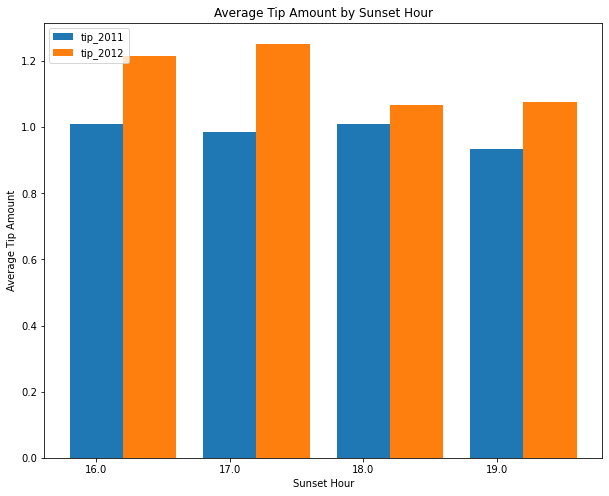

In [436]:
import matplotlib.pyplot as plt

# Set the width of each bar
width = 0.4
fig = plt.figure(figsize=(10, 8))
# Plot the first set of bars
plt.bar(tip_df_2011['sunset_hour'], tip_df_2011['avg_tip_amt'], width=width, align='edge', label='tip_2011')

# Plot the second set of bars with a small offset
plt.bar(tip_df_2012['sunset_hour'] + width, tip_df_2012['avg_tip_amt'], width=width, align='edge', label='tip_2012')

# Add labels and title
plt.xlabel('Sunset Hour')
plt.ylabel('Average Tip Amount')
plt.title('Average Tip Amount by Sunset Hour')

plt.legend(frameon=True, loc="upper left")
# Adjust the x-axis tick marks
plt.xticks(tip_df_2011['sunset_hour'] + width / 2, tip_df_2011['sunset_hour'])

# Show the plot
plt.show()
